In [1]:
import pickle as pkl
import pk_plot_library as pplib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from figrid.data_container import DataContainer

pplib.imports()
COSMO = '/Users/cosinga/overleaf/hi_cosmo/figures/'

In [2]:
ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/8-12_pkdatasort.pkl', 'rb'))
print(ds.getAttrs())

ds.tickArgs(direction = 'in', right = True, top = True, labelsize = 14)
ds.legendArgs(frameon = False, loc = 'upper right', fontsize = 14, slc = (-1, -1))

ds.axisLabelArgs('both', fontsize = 16)
ds.rowLabelArgs(pos = [0.05, 0.05], fontsize = 16, ha = 'left', va = 'bottom')
ds.colLabelArgs(pos = [0.5, 0.95], fontsize = 16, ha = 'center' , va = 'top')
ds.axisArgs(xscale = 'log', yscale = 'log', xlim = [0.04, 10])

ds.setOrder('space', ['real', 'redshift', 'rsd'])

ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('snapshot', [99, 67, 50], ['z = 0.0', 'z = 0.5', 'z = 1.0'])
# ds.displayAs('color', ['blue', 'red', 'resolved'], 
#              ['HI $\\times$ Blue Bias', 'HI $\\times$ Red Bias', 'HI $\\times$ Galaxy Bias'])
ds.displayAs('HI_fieldname', ['hisubhalo', 'vn', 'hiptl'], ['Galaxy Centers', 'All Particles', 'Particles in Galaxies'])

ds.setColors('HI_fieldname', ['firebrick', 'saddlebrown', 'sandybrown'], ['vn', 'hiptl', 'hisubhalo'])
ds.setColors('color', ['red', 'blue', 'gray'], ['red', 'blue', 'resolved'])

ds.setXLabel(pplib.wnum())

['path', 'result_type', 'result_runtime', 'is_auto', 'box', 'simname', 'sim_resolution', 'num_part', 'grid_resolution', 'snapshot', 'redshift', 'axis', 'fieldname', 'is_hydrogen', 'is_atomic', 'is_molecular', 'is_particle', 'is_groupcat', 'is_matter', 'mas', 'space', 'compute_xi', 'compute_slice', 'color', 'gal_species', 'gal_res', 'color_cut', 'ptl_species', 'map', 'model', 'HI_fieldname', 'projection', 'HI_res', 'censat', 'post_process', 'numerator', 'denominator']


In [3]:
def calc_obs_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    auto = ds.getMatching(ip)
    biases = []
    for i in range(len(auto)):
        
        data = [auto[i].data[0], np.sqrt(auto[i].data[1] / ptl_auto.data[1])]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(auto[i].attrs))
        dc.add('post_process','obs_bias')
        dc.add('is_auto', False)
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')

        biases.append(dc)
    return biases

def calc_th_bias(ip):
    ptlip = {'is_auto':True, 'fieldname':'ptl', 'ptl_species':'ptl', 'mas':ip['mas'],
            'path':ip['path'], 'grid_resolution':ip['grid_resolution'],
            'simname':ip['simname'], 'axis':0, 'snapshot':ip['snapshot'],
            'space':ip['space']}
    ptl_auto = ds.getMatching(ptlip)
    if len(ptl_auto) > 1:
        print('found too many particles')
        for i in ptl_auto:
            print(i.attrs)
    
    ptl_auto = ptl_auto[0]
    
    cross = ds.getMatching(ip)
    biases = []
    for i in range(len(cross)):
        
        data = [cross[i].data[0], cross[i].data[1] / ptl_auto.data[1]]
        dc = DataContainer(data)
        dc.update(copy.deepcopy(cross[i].attrs))
        dc.add('post_process','theory_bias')
        dc.add('denominator', 'ptl')
        dc.add('_post_time', 'now')
        biases.append(dc)
    return biases
def save_bias(biases):
    SAVE_ATTRS = ['simname', 'snapshot', 'space', 'post_process', 'color', 'model']
    bvals = []
    for bias in biases:
        bval = bias.getData()[1][1]
        attrs = [bias.get(attr) for attr in SAVE_ATTRS]
        bvals.append([bval, attrs])
    return bvals

In [4]:
simnames = ['tng100', 'tng300']
snapshots = [50, 67, 99]
spaces = ['real', 'redshift']
bvals = []
for name in simnames:
    for snap in snapshots:
        for space in spaces:
            
            if not (snap == 67 and name == 'tng300'):
                print("\n", name, snap, space)
                hiip = {'is_auto':True, "HI_fieldname":['vn', 'hiptl'],      
                  'axis':0, 'grid_resolution':800, 'simname': name,
                  'mas':'CICW', 'snapshot':snap, 'space':space,
                 'path':'fiducial', 'post_process':'no key found'}
                obs_biases = calc_obs_bias(hiip)
                print('hi biases:', len(obs_biases))
                ds.extend(obs_biases)
                bvals.extend(save_bias(obs_biases))
                galip = {'gal_res':'diemer',
                          'gal_species':'stmass', 'sim_resolution':'high', 
                         'axis':0, 'grid_resolution':800,
                          'censat':['no key found', 'both'], 'mas':'CICW', 
                         'color': ['blue', 'red', 'resolved'], 'fieldname':'galaxy',
                         'path':'fiducial', 'simname':name, 'space':space,
                        'snapshot':snap, 'post_process':'no key found'}
                obs_biases = calc_obs_bias(galip)
                print('galaxy biases:', len(obs_biases))
                bvals.extend(save_bias(obs_biases))
                ds.extend(obs_biases)


 tng100 50 real
hi biases: 5
galaxy biases: 3

 tng100 50 redshift
hi biases: 5
galaxy biases: 3

 tng100 67 real
hi biases: 5
galaxy biases: 3

 tng100 67 redshift
hi biases: 5
galaxy biases: 3

 tng100 99 real
hi biases: 5
galaxy biases: 3

 tng100 99 redshift
hi biases: 5
galaxy biases: 3

 tng300 50 real
found too many particles
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.703163862228394, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high', 'num_part': 2740098112, 'grid_resolution': 800, 'snapshot': 50, 'redshift': 0.9972942257819404, 'axis': 0, 'fieldname': 'ptl', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': True, 'is_groupcat': False, 'is_matter': True, 'mas': 'CICW', 'space': 'real', 'compute_xi': True, 'compute_slice': False, 'ptl_species': 'ptl'}
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.2175133228302, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high'

In [4]:
def add_ptl(fg):
    ptlip = dict(
        path = 'fiducial',
        fieldname = 'ptl',
        ptl_species = ['ptl', 'no key found'],
        snapshot = [99, 50],
        simname = 'tng300'
    )
    ptlfg = ds.figrid('space', '', 'snapshot', ptlip)
    ptlfg.autoNorm({'space':'real'})
    ptlfg.plotArgs({}, color = 'black')
    ptlfg.legendArgs(rm_legend = True)
    ptlfg.plot(axes = fg.axes)
    return

## Check Kaiser Linearity

<a href="https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf">Link to Reference</a>



Kaiser effect predicts the following relationship between the real and redshift space matter power spectra, assuming that we are in the linear regime:

$P^{s}_m (k) = P^r_m (k) (1 + 2/3 f + 1/5 f^2)$

Let's examine how well this works in TNG300, and make sure I'm doing this correctly

In [6]:
# compare to the example given in the reference - f = 0.774
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
z = 0.57
D = cosmo.growthFactor(z, derivative = 0)
dDdz = cosmo.growthFactor(z, derivative = 1)
alpha_eff = -dDdz * (1.0 + z) / D
print(D, dDdz, alpha_eff)


0.7441423588987737 -0.36881430866791926 0.7781286170371069


seems like I'm calculating the growth rate f correctly.



By definition, in the linear regime $P(k, z) = D(z)^2 P(k, z = 0)$ should be true. (<a href="https://en.wikipedia.org/wiki/Matter_power_spectrum">Wikipedia<a>)

Let's compare the D(z) from TNG300's matter power spectra, calculated with $\sqrt{P(k, z) / P(k, z=0)}$ to the one computed by colossus.

In [18]:
def kaiser(z, bias):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    beta = f / bias
    return (1 + 2/3 * beta + 1/5 * beta**2)

0.6178310600838924 0.6087853411565883


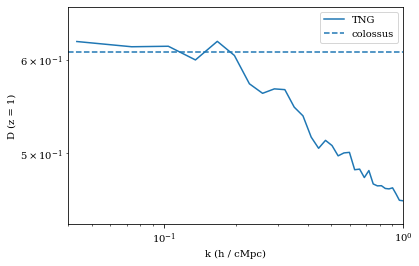

In [10]:

ptlip = dict(
    path = 'fiducial',
    fieldname = 'ptl',
    ptl_species = ['ptl'],
    snapshot = [99],
    simname = 'tng300',
    space = ['real'],
    post_process = 'no key found'
)
pk0 = ds.getMatching(ptlip)[0].getData()
ptlip['snapshot'] = 50
pk1 = ds.getMatching(ptlip)[0].getData()
tng_d = np.sqrt(pk1[1] / pk0[1])
plt.plot(pk0[0], tng_d, label = 'TNG')
plt.loglog()
plt.xlim(.04, 1)
xlim = plt.xlim()
plt.axhline(cosmo.growthFactor(1), label = 'colossus', linestyle = '--')

d_val = np.mean(tng_d[:3])
print(d_val, cosmo.growthFactor(1))
plt.ylabel("D (z = 1)")
plt.xlabel("k (h / cMpc)")
plt.legend()
# appear to agree pretty well

Now let's compare the real space power spectra to the redshift space power spectra for matter. The ratio of the two should approach the Kaiser limit, $(1 + 2/3 f + 1/5 f^2)$

The row values for ptl_species: ['ptl']
The column values for snapshot: [99, 50]


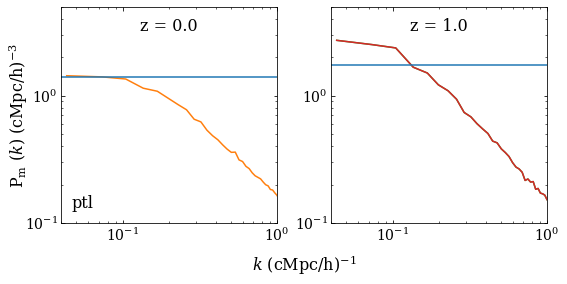

In [19]:

ptlip = dict(
    path = 'fiducial',
    fieldname = 'ptl',
    ptl_species = ['ptl'],
    snapshot = [99, 50],
    simname = 'tng300',
    space = ['real', 'redshift'],
    post_process = 'no key found'
)
fg = ds.figrid('space', 'ptl_species', 'snapshot', ptlip)
fg.autoNorm({'space':'real'})
# fg.plotArgs({'space':'real'}, label = 'real x kaiser', color = 'black')
# fg.plotArgs({'space':'redshift'}, label = 'redshift', color = 'red')
fg.legendArgs(rm_legend= True)
fg.axisArgs(xlim = (0.04, 1), ylim = (1e-1, 5))
fg.setYLabel(pplib.pklab('m'))

fg.plot()
fg.axes[0,0].axhline(kaiser(0, 1))
fg.axes[0, 1].axhline(kaiser(1, 1))

The row values for simname: ['tng100', 'tng300']
The column values for snapshot: [99, 50]
0.8395442896552915 2.220446049250313e-16 tng100
1.4923746293349207 0.9972942257819404 tng100
0.6762538655657683 2.220446049250313e-16 tng300
1.2512342415607032 0.9972942257819404 tng300


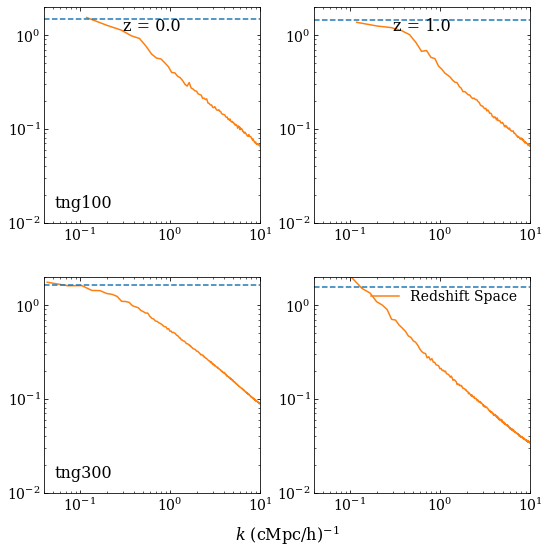

In [9]:
# now let's recreate paco's plot
ip = {'path': 'fiducial', 'simname':['tng100','tng300'], 'space':['real','redshift'],
     'fieldname':['vn'], 'snapshot':[99, 50], 'post_process':'no key found'}
fg = ds.figrid('space', 'simname', 'snapshot', ip)
fg.autoNorm({'space':'real'})
biasip = {'post_process':'obs_bias', 'fieldname':['vn'], 'denominator':'ptl',
        '_post_time':'now', 'path':'fiducial', 'space':'real'}
fg.axisArgs(ylim = (1e-2, 2))
fg.plot()
for i in range(fg.dim[0]):
    for j in range(fg.dim[1]):
        dc_list = fg.panels[i, j]
        ax = fg.axes[i, j]

        biasip['snapshot'] = dc_list[0].get('snapshot')
        biasip['simname'] = dc_list[0].get('simname')
        bias = ds.getMatching(biasip)
        if len(bias) > 1:
            print("too many biases found")
            print(bias)
        bias = bias[0].getData()[1][0]
        z = dc_list[0].get('redshift')
        print(bias, z, dc_list[0].get('simname'))
        ax.axhline(kaiser(z, bias), linestyle = 'dashed')
        
        

The row values for simname: ['tng100', 'tng300']
The column values for snapshot: [99, 50]


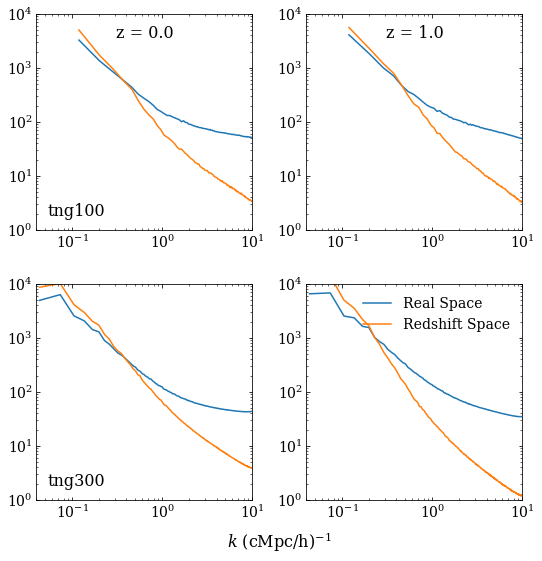

In [10]:
ip = {'path': 'fiducial', 'simname':['tng100','tng300'], 'space':['real','redshift'],
     'fieldname':['vn'], 'snapshot':[99, 50], 'post_process':'no key found'}
fg = ds.figrid('space', 'simname', 'snapshot', ip)
biasip = {'post_process':'obs_bias', 'fieldname':['vn'], 'denominator':'ptl',
        '_post_time':'now', 'path':'fiducial', 'space':'real'}
fg.axisArgs(ylim = (1, 1e4))
fg.plot()

The row values for ptl_species: ['ptl', 'dm']
The column values for snapshot: [99, 50]
0.5213661783670551 0.5271700878935701
1.401941990633717
0.8555568525418836 0.8736161252875991
1.7167667406141973
0.8555568525418836 0.8736161252875991
1.7167667406141973
0.5213661783670551 0.5271700878935701
1.401941990633717
0.8555568525418836 0.8736161252875991
1.7167667406141973
0.8555568525418836 0.8736161252875991
1.7167667406141973


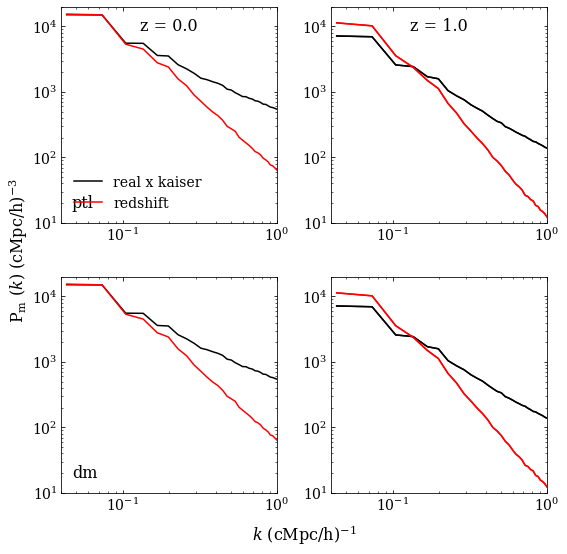

In [11]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')

def kaiser(dc):
    data = dc.getData()
    x = data[0]; y = data[1]
    z = dc.get('redshift')
    dDdz = cosmo.growthFactor(z, derivative = 1)
#     D = cosmo.growthFactor(z)
    if z < 0.5:
        D = 1
    else:
        D = tng_d[0]
    f = -dDdz * (1 + z) / D
    om_f = cosmo.Om(z)**0.545
    print(f, om_f)
    kaiser = (1 + 2/3 * f + 1/5 * f**2)
    print(kaiser)
    newy = y * kaiser
    dc.setData([x, newy])
    return dc
    
ptlip = dict(
    path = 'fiducial',
    fieldname = 'ptl',
    ptl_species = ['ptl','dm'],
    snapshot = [99, 50],
    simname = 'tng300',
    space = ['real', 'redshift'],
    post_process = 'no key found'
)
fg = ds.figrid('space', 'ptl_species', 'snapshot', ptlip)
fg.adjustData({'space':'real'}, kaiser)
fg.plotArgs({'space':'real'}, label = 'real x kaiser', color = 'black')
fg.plotArgs({'space':'redshift'}, label = 'redshift', color = 'red')
fg.legendArgs(slc = (0,0), loc = 'lower left')
fg.axisArgs(xlim = (0.04, 1), ylim = (10, 2e4))
fg.setYLabel(pplib.pklab('m'))
fg.plot()

I'm unsure why the z = 1 results do not agree with the Kaiser prediction for the particle distributions. I'm 95% sure that the redshift-space power spectrum is correct, at least Paco and I match up precisely with our HI distributions and I use the same routine to put everything into redshift-space.


The monopole for the HI auto power spectrum should follow this equation in the linear regime.

$P_{\mathrm{HI}}^s (k) = (1 + 2/3 \beta + 1/5 \beta^2)b_{\mathrm{HI}}^2 P^L_m (k)$

$\beta = f(a) / b_{\mathrm{HI}}, f(a)  = \frac{\partial \mathrm{ln} D_+ (a)}{\partial \mathrm{ln} a}$

Let's check if these agree.

The row values for : ['no key found']
The column values for snapshot: [99, 50]
{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.647356033325195, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high', 'num_part': 2740098112, 'grid_resolution': 800, 'snapshot': 50, 'redshift': 0.9972942257819404, 'axis': 0, 'fieldname': 'ptl', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': True, 'is_groupcat': False, 'is_matter': True, 'mas': 'CICW', 'space': 'redshift', 'compute_xi': True, 'compute_slice': False, 'ptl_species': 'ptl'}

{'path': 'fiducial', 'result_type': 'pk', 'result_runtime': 24.08865261077881, 'is_auto': True, 'box': 205.0, 'simname': 'tng300', 'sim_resolution': 'high', 'num_part': 2740098112, 'grid_resolution': 800, 'snapshot': 50, 'redshift': 0.9972942257819404, 'axis': 0, 'fieldname': 'ptl', 'is_hydrogen': False, 'is_atomic': False, 'is_molecular': False, 'is_particle': True, 'is_groupcat': False, 'is_matter': T

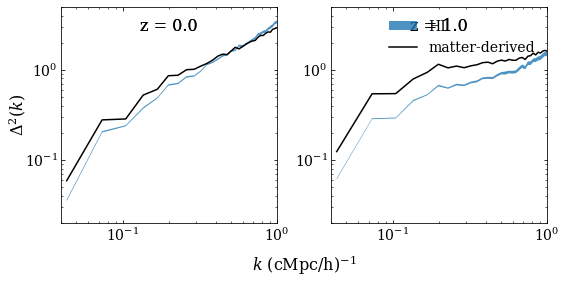

<Figure size 540x270 with 0 Axes>

In [81]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
biasip = {'post_process':'obs_bias', 'fieldname':['vn', 'hiptl'], 'denominator':'ptl',
               'simname':'tng300', '_post_time':'now', 'path':'fiducial', 'space':'real'}



def renorm_pk(dc):
    data = dc.getData()
    x = data[0]; y = data[1]
    newy = y * x**3 / 2/ np.pi**2
    dc.setData([x, newy])
    return dc

def matter_pk_const(dc):
    biasip = {'post_process':'obs_bias', 'fieldname':['vn', 'hiptl'], 'denominator':'ptl',
               'simname':'tng300', '_post_time':'now', 'path':'fiducial', 'space':'real'}
    f = cosmo.Om(dc.get('redshift'))**0.545
#     f = cosmo.growthFactor(dc.get('redshift'), derivative = 1)
    biasip['snapshot'] = dc.get('snapshot')
    biases = ds.getMatching(biasip)
    total = 0; count = 0
    for b in biases:
        data = b.getData()
        
        total += data[1][1]
        count += 1
    bhi = total / count
    beta = f / bhi
    
    data = dc.getData()
    x = data[0]; y = data[1]
    newy = (1 + 2/3*beta + 1/5*beta**2) * bhi**2 * y
    dc.setData([x, newy])
    dc = renorm_pk(dc)
    return dc

ptlip = dict(
    path = 'fiducial',
    fieldname = 'ptl',
    ptl_species = ['ptl'],
    snapshot = [99, 50],
    simname = 'tng300',
    space = 'redshift',
    post_process = 'no key found'
)
ptlfg = ds.figrid('space', '', 'snapshot', ptlip)
del ptlfg.panels[0, 1][0]
ptlfg.plotArgs({}, color = 'black', label = 'matter-derived')
ptlfg.legendArgs()
ptlfg.adjustData({}, matter_pk_const)
ds.printMatching(ptlip)
ip = {'path': 'fiducial', 'simname':'tng300', 'space':['redshift'],
     'fieldname':['vn', 'hiptl'], 'snapshot':[99, 50], 'post_process':'no key found'}

fg = ds.figrid('simname', '', 'snapshot', ip)
fg.adjustData({}, renorm_pk)
fg.autoFill(alpha = 0.8, label = 'HI')
fg.legendArgs(rm_legend = True)
ptlfg.axisArgs(xlim = (0.04, 1), ylim = (2e-2, 5))
fg.setYLabel(r"$\Delta^2 (k)$")

fg.plot()
ptlfg.plot(axes = fg.axes)


The row values for : ['no key found']
The column values for snapshot: [99, 50]
The row values for : ['no key found']
The column values for snapshot: [99, 50]


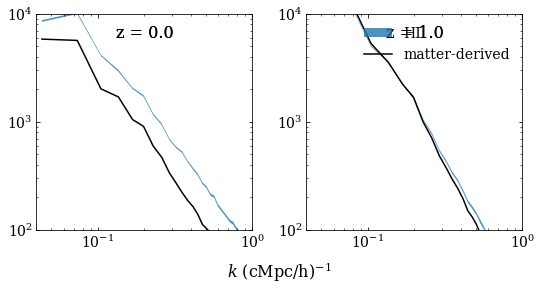

<Figure size 540x270 with 0 Axes>

In [45]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
biasip = {'post_process':'obs_bias', 'fieldname':['vn', 'hiptl'], 'denominator':'ptl',
               'simname':'tng300', '_post_time':'now', 'path':'fiducial', 'space':'real'}



# def renorm_pk(dc):
#     data = dc.getData()
#     x = data[0]; y = data[1]
#     newy = y * x**3 / 2/ np.pi**2
#     dc.setData([x, newy])
#     return dc

def matter_pk_const(dc):
    biasip = {'post_process':'obs_bias', 'fieldname':['vn', 'hiptl'], 'denominator':'ptl',
               'simname':'tng300', '_post_time':'now', 'path':'fiducial', 'space':'real'}
#     f = cosmo.Om(dc.get('redshift'))**0.55
    f = cosmo.growthFactor(dc.get('redshift'), derivative = 1)
    biasip['snapshot'] = dc.get('snapshot')
    biases = ds.getMatching(biasip)
    total = 0; count = 0
    for b in biases:
        data = b.getData()
        
        total += data[1][1]
        count += 1
    bhi = total / count
    beta = f / bhi
    
    data = dc.getData()
    x = data[0]; y = data[1]
    newy = (1 + 2/3*beta + 1/5*beta**2) * bhi**2 * y
    dc.setData([x, newy])
#     dc = renorm_pk(dc)
    return dc

ptlip = dict(
    path = 'fiducial',
    fieldname = 'ptl',
    ptl_species = ['ptl'],
    snapshot = [99, 50],
    simname = 'tng300',
    space = 'redshift',
    post_process = 'no key found'
)
ptlfg = ds.figrid('space', '', 'snapshot', ptlip)
del ptlfg.panels[0, 1][0]
ptlfg.plotArgs({}, color = 'black', label = 'matter-derived')
ptlfg.legendArgs()
ptlfg.adjustData({}, matter_pk_const)
ip = {'path': 'fiducial', 'simname':'tng300', 'space':['redshift'],
     'fieldname':['vn', 'hiptl'], 'snapshot':[99, 50], 'post_process':'no key found'}

fg = ds.figrid('simname', '', 'snapshot', ip)
# fg.adjustData({}, renorm_pk)
fg.autoFill(alpha = 0.8, label = 'HI')
fg.legendArgs(rm_legend = True)
ptlfg.axisArgs(xlim = (0.04, 1), ylim = (1e2, 1e4))
fg.plot()

ptlfg.plot(axes = fg.axes)
